In [19]:
# Importing necessary libraries from PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch.nn.functional as F
import numpy as np

# Importing other necessary packages
import numpy as np
from PIL import Image

# Optional: for visualization and additional utilities
import matplotlib.pyplot as plt


# Load Pre-trained Model

In [20]:
from torchvision import models
import torch.nn as nn

# Load the pretrained MobileNetV3 model
model = models.mobilenet_v3_large(pretrained=True)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False


In [21]:
# Print the model architecture
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

# Step 1: Load the data

In [22]:
from dataset_prep import *

In [23]:
# PARAMS
BATCH_SIZE = 200
NUM_WORKERS = 8
PIN_MEMORY = False
SHUFFLE = False # preprocessed data is already shuffled
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
PATIENCE = 5
# NUM_BATCHES = 10 this one when want to break early, train just one batch etc.
LOAD_MODEL = False

In [24]:
# Base path
base_path = '/Users/ruimaciel/Desktop/Barcelona/DL_Image/Final_project/data_prepped'

# Define the datasets with correct paths
train_ds = Prepped_Painting_Dataset(data_dir=os.path.join(base_path, 'train_prep'))
valid_ds = Prepped_Painting_Dataset(data_dir=os.path.join(base_path, 'val_prep'))
test_ds = Prepped_Painting_Dataset(data_dir=os.path.join(base_path, 'test_prep'))


train_loader = DataLoader(train_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE,
                          persistent_workers=True)


valid_loader = DataLoader(valid_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE,
                          persistent_workers=True)


test_loader = DataLoader(test_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE,
                          persistent_workers=True)

# Step 2: Unfreeze the Last Layer

In [25]:
# Assuming you have 'num_classes' as the number of your target classes
num_classes = 27  # Change this to your number of classes

# Replace the classifier - note for MobileNetV3, the final classifier is named 'classifier'
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

# Step 3: Move the Model to a GPU (Optional)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cpu


# Step 4: Define Loss Function and Optimizer

In [27]:
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = Adam(model.classifier.parameters(), lr=0.001, weight_decay=0.01)  # Add L2 regularization


# Step 5: Training the Model

In [28]:
# model.train()  # Set the model to training mode
# num_epochs = 5  # Number of training epochs

# # Lists to track losses
# train_losses = []
# val_losses = []

# for epoch in range(num_epochs):
#     # Training phase
#     model.train()  # Ensure the model is in training mode
#     running_train_loss = 0.0
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device

#         # Convert labels to one-hot encoding
#         labels = torch.nn.functional.one_hot(labels.squeeze(), num_classes=26).float()

#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()  # Clear gradients w.r.t. parameters
#         loss.backward()  # Backward pass
#         optimizer.step()  # Perform a single optimization step

#         running_train_loss += loss.item()

#     epoch_train_loss = running_train_loss / len(train_loader)
#     train_losses.append(epoch_train_loss)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}')

#     # Validation phase
#     model.eval()  # Set the model to evaluation mode
#     running_val_loss = 0.0
#     with torch.no_grad():
#         for inputs, labels in valid_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             # Convert labels to one-hot encoding
#             labels = torch.nn.functional.one_hot(labels.squeeze(), num_classes=26).float()

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             running_val_loss += loss.item()

#     epoch_val_loss = running_val_loss / len(valid_loader)
#     val_losses.append(epoch_val_loss)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss:.4f}')

# # Plotting training and validation loss
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
# plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()


In [29]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

Epoch [1/20] Training: 100%|██████████| 111/111 [13:15<00:00,  7.16s/it, loss=2.59]

Epoch [1/20], Training Loss: 2.9225


Epoch [1/20], Validation Loss: 2.2443
Validation loss improved. Resetting early stopping counter and saving model parameters.


Epoch [2/20] Training: 100%|██████████| 111/111 [13:00<00:00,  7.03s/it, loss=2.53]


Epoch [2/20], Training Loss: 2.5252
Epoch [2/20], Validation Loss: 2.1143
Validation loss improved. Resetting early stopping counter and saving model parameters.


Epoch [3/20] Training: 100%|██████████| 111/111 [12:33<00:00,  6.79s/it, loss=2.45]


Epoch [3/20], Training Loss: 2.4060
Epoch [3/20], Validation Loss: 2.0684
Validation loss improved. Resetting early stopping counter and saving model parameters.


Epoch [4/20] Training: 100%|██████████| 111/111 [12:38<00:00,  6.83s/it, loss=2.41]


Epoch [4/20], Training Loss: 2.3325
Epoch [4/20], Validation Loss: 2.0431
Validation loss improved. Resetting early stopping counter and saving model parameters.


Epoch [5/20] Training: 100%|██████████| 111/111 [12:40<00:00,  6.85s/it, loss=2.42]


Epoch [5/20], Training Loss: 2.2882
Epoch [5/20], Validation Loss: 2.0283
Validation loss improved. Resetting early stopping counter and saving model parameters.


Epoch [6/20] Training: 100%|██████████| 111/111 [12:41<00:00,  6.86s/it, loss=2.36]


Epoch [6/20], Training Loss: 2.2525
Epoch [6/20], Validation Loss: 2.0181
Validation loss improved. Resetting early stopping counter and saving model parameters.


Epoch [7/20] Training: 100%|██████████| 111/111 [12:42<00:00,  6.87s/it, loss=2.31]


Epoch [7/20], Training Loss: 2.2239
Epoch [7/20], Validation Loss: 2.0094
No improvement in validation loss. Early stopping counter: 1


Epoch [8/20] Training: 100%|██████████| 111/111 [12:44<00:00,  6.89s/it, loss=2.34]


Epoch [8/20], Training Loss: 2.2027
Epoch [8/20], Validation Loss: 2.0036
Validation loss improved. Resetting early stopping counter and saving model parameters.


Epoch [9/20] Training: 100%|██████████| 111/111 [12:41<00:00,  6.86s/it, loss=2.33]


Epoch [9/20], Training Loss: 2.1860
Epoch [9/20], Validation Loss: 1.9988
No improvement in validation loss. Early stopping counter: 1


Epoch [10/20] Training: 100%|██████████| 111/111 [12:41<00:00,  6.86s/it, loss=2.24]


Epoch [10/20], Training Loss: 2.1677
Epoch [10/20], Validation Loss: 1.9938
No improvement in validation loss. Early stopping counter: 2
Early stopping triggered. Stopping training.
Loaded best model parameters from training.


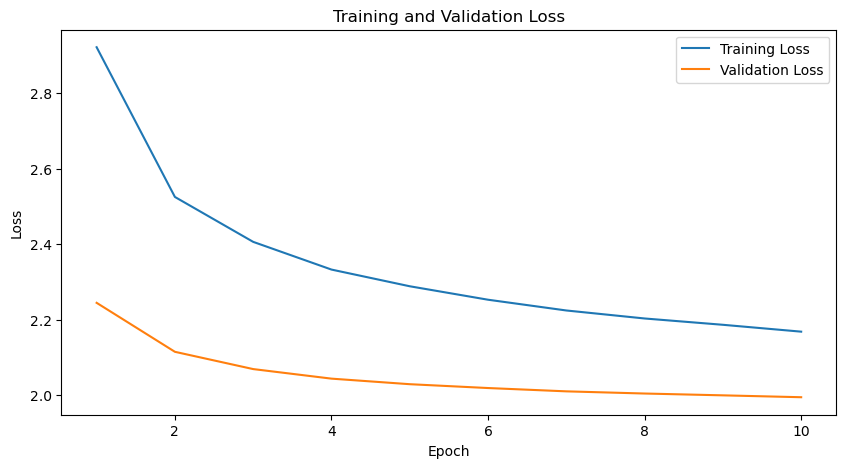

In [30]:
# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-6)

# Training and validation loops
num_epochs = 20  # Number of training epochs
patience = 2    # Number of epochs to wait for improvement
min_delta = 0.01  # Minimum change to qualify as an improvement

# Lists to track losses
train_losses = []
val_losses = []

# Early stopping variables
best_val_loss = float('inf')
early_stop_counter = 0
best_model_params = None

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Ensure the model is in training mode
    running_train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device

        # Ensure labels are 1D tensors of class indices
        if labels.ndimension() > 1:
            labels = labels.squeeze()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients w.r.t. parameters
        loss.backward()  # Backward pass
        optimizer.step()  # Perform a single optimization step

        running_train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Ensure labels are 1D tensors of class indices
            if labels.ndimension() > 1:
                labels = labels.squeeze()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_losses.append(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss:.4f}')

    # Adjust the learning rate based on the validation loss
    scheduler.step(epoch_val_loss)

    # Early stopping check
    if epoch_val_loss < best_val_loss - min_delta:
        best_val_loss = epoch_val_loss
        early_stop_counter = 0
        best_model_params = model.state_dict().copy()  # Save the best model parameters
        print("Validation loss improved. Resetting early stopping counter and saving model parameters.")
    else:
        early_stop_counter += 1
        print(f"No improvement in validation loss. Early stopping counter: {early_stop_counter}")

    if early_stop_counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break

# Load the best model parameters before plotting
if best_model_params is not None:
    model.load_state_dict(best_model_params)
    print("Loaded best model parameters from training.")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



# Step 6: Evaluate the Model

In [31]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Inference with Softmax and Metrics Calculation on Test Dataset
model.eval()  # Set the model to evaluation mode
softmax = nn.Softmax(dim=1)
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:  # Assume you have a DataLoader 'test_loader'
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = softmax(outputs)  # Apply softmax to get probabilities
        _, predicted = torch.max(probabilities, 1)  # Get the index of the max probability
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions) * 100
print(f'Overall Accuracy of the model on the test images: {accuracy:.2f}%')

# Calculate precision, recall, f1-score, and support for each class
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_predictions, average=None)

# Print precision, recall, f1-score, and accuracy for each class
for i in range(num_classes):
    class_precision = precision[i]
    class_recall = recall[i]
    class_f1 = f1[i]
    class_support = support[i]
    class_accuracy = 100 * (np.sum((np.array(all_labels) == i) & (np.array(all_predictions) == i))) / class_support
    print(f'Class {i}:')
    print(f'  Precision: {class_precision:.4f}')
    print(f'  Recall: {class_recall:.4f}')
    print(f'  F1 Score: {class_f1:.4f}')
    print(f'  Accuracy: {class_accuracy:.2f}%')

# Print overall precision, recall, f1-score
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
print(f'Overall Precision: {overall_precision:.4f}')
print(f'Overall Recall: {overall_recall:.4f}')
print(f'Overall F1 Score: {overall_f1:.4f}')

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)]))



Overall Accuracy of the model on the test images: 39.84%
Class 0:
  Precision: 0.3682
  Recall: 0.3189
  F1 Score: 0.3418
  Accuracy: 22000.00%
Class 1:
  Precision: 0.2535
  Recall: 0.3280
  F1 Score: 0.2860
  Accuracy: 64700.00%
Class 2:
  Precision: 0.2123
  Recall: 0.3720
  F1 Score: 0.2703
  Accuracy: 87600.00%
Class 3:
  Precision: 0.4615
  Recall: 0.1295
  F1 Score: 0.2022
  Accuracy: 3900.00%
Class 4:
  Precision: 0.3969
  Recall: 0.3040
  F1 Score: 0.3443
  Accuracy: 38300.00%
Class 5:
  Precision: 0.5352
  Recall: 0.3500
  F1 Score: 0.4232
  Accuracy: 32700.00%
Class 6:
  Precision: 0.3333
  Recall: 0.0143
  F1 Score: 0.0274
  Accuracy: 300.00%
Class 7:
  Precision: 0.4692
  Recall: 0.5446
  F1 Score: 0.5041
  Accuracy: 13000.00%
Class 8:
  Precision: 0.5870
  Recall: 0.6260
  F1 Score: 0.6059
  Accuracy: 38500.00%
Class 9:
  Precision: 0.4282
  Recall: 0.2920
  F1 Score: 0.3472
  Accuracy: 34100.00%
Class 10:
  Precision: 0.3229
  Recall: 0.2280
  F1 Score: 0.2673
  Accuracy

## Another optimizer

Epoch [1/20] Training: 100%|██████████| 111/111 [12:33<00:00,  6.79s/it, loss=2.49]


Epoch [1/20], Training Loss: 2.2257
Epoch [1/20], Validation Loss: 2.0488
Validation loss improved. Resetting early stopping counter and saving model parameters.


Epoch [2/20] Training: 100%|██████████| 111/111 [12:32<00:00,  6.78s/it, loss=2.39]


Epoch [2/20], Training Loss: 2.2223
Epoch [2/20], Validation Loss: 2.0429
No improvement in validation loss. Early stopping counter: 1


Epoch [3/20] Training: 100%|██████████| 111/111 [12:33<00:00,  6.79s/it, loss=2.3] 


Epoch [3/20], Training Loss: 2.2098
Epoch [3/20], Validation Loss: 2.0397
No improvement in validation loss. Early stopping counter: 2
Early stopping triggered. Stopping training.
Loaded best model parameters from training.


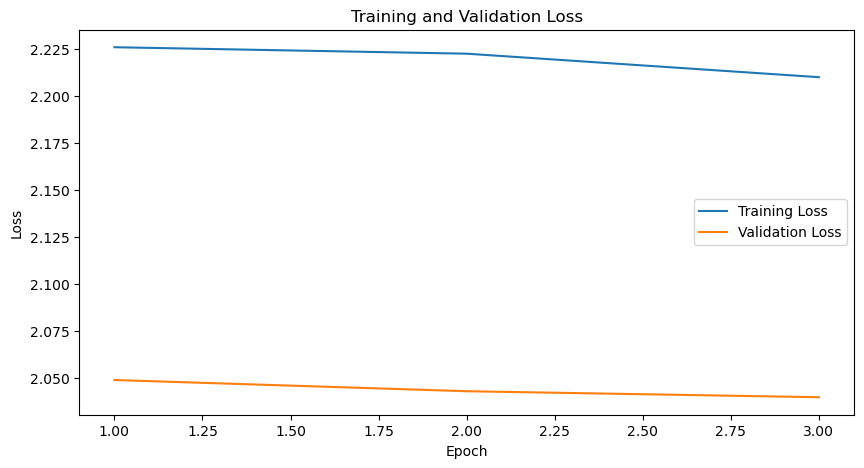

Overall Accuracy of the model on the test images: 38.17%
Class 0:
  Precision: 0.3261
  Recall: 0.3543
  F1 Score: 0.3396
  Accuracy: 27600.00%
Class 1:
  Precision: 0.2237
  Recall: 0.3740
  F1 Score: 0.2799
  Accuracy: 83600.00%
Class 2:
  Precision: 0.2034
  Recall: 0.4340
  F1 Score: 0.2770
  Accuracy: 106700.00%
Class 3:
  Precision: 0.4333
  Recall: 0.0935
  F1 Score: 0.1538
  Accuracy: 3000.00%
Class 4:
  Precision: 0.3830
  Recall: 0.2980
  F1 Score: 0.3352
  Accuracy: 38900.00%
Class 5:
  Precision: 0.5949
  Recall: 0.2320
  F1 Score: 0.3338
  Accuracy: 19500.00%
Class 6:
  Precision: 0.8000
  Recall: 0.0571
  F1 Score: 0.1067
  Accuracy: 500.00%
Class 7:
  Precision: 0.5128
  Recall: 0.5357
  F1 Score: 0.5240
  Accuracy: 11700.00%
Class 8:
  Precision: 0.6017
  Recall: 0.5734
  F1 Score: 0.5872
  Accuracy: 34400.00%
Class 9:
  Precision: 0.7063
  Recall: 0.2260
  F1 Score: 0.3424
  Accuracy: 16000.00%
Class 10:
  Precision: 0.3520
  Recall: 0.1380
  F1 Score: 0.1983
  Accurac

In [32]:
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-6)

# Training and validation loops
num_epochs = 20  # Number of training epochs
patience = 2    # Number of epochs to wait for improvement
min_delta = 0.01  # Minimum change to qualify as an improvement

# Lists to track losses
train_losses = []
val_losses = []

# Early stopping variables
best_val_loss = float('inf')
early_stop_counter = 0
best_model_params = None

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Ensure the model is in training mode
    running_train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device

        # Ensure labels are 1D tensors of class indices
        if labels.ndimension() > 1:
            labels = labels.squeeze()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients w.r.t. parameters
        loss.backward()  # Backward pass
        optimizer.step()  # Perform a single optimization step

        running_train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Ensure labels are 1D tensors of class indices
            if labels.ndimension() > 1:
                labels = labels.squeeze()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_losses.append(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss:.4f}')

    # Adjust the learning rate based on the validation loss
    scheduler.step(epoch_val_loss)

    # Early stopping check
    if epoch_val_loss < best_val_loss - min_delta:
        best_val_loss = epoch_val_loss
        early_stop_counter = 0
        best_model_params = model.state_dict().copy()  # Save the best model parameters
        print("Validation loss improved. Resetting early stopping counter and saving model parameters.")
    else:
        early_stop_counter += 1
        print(f"No improvement in validation loss. Early stopping counter: {early_stop_counter}")

    if early_stop_counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break

# Load the best model parameters before plotting
if best_model_params is not None:
    model.load_state_dict(best_model_params)
    print("Loaded best model parameters from training.")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Inference with Softmax and Metrics Calculation on Test Dataset
model.eval()  # Set the model to evaluation mode
softmax = nn.Softmax(dim=1)
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:  # Assume you have a DataLoader 'test_loader'
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = softmax(outputs)  # Apply softmax to get probabilities
        _, predicted = torch.max(probabilities, 1)  # Get the index of the max probability
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions) * 100
print(f'Overall Accuracy of the model on the test images: {accuracy:.2f}%')

# Calculate precision, recall, f1-score, and support for each class
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_predictions, average=None)

# Print precision, recall, f1-score, and accuracy for each class
for i in range(num_classes):
    class_precision = precision[i]
    class_recall = recall[i]
    class_f1 = f1[i]
    class_support = support[i]
    class_accuracy = 100 * (np.sum((np.array(all_labels) == i) & (np.array(all_predictions) == i))) / class_support
    print(f'Class {i}:')
    print(f'  Precision: {class_precision:.4f}')
    print(f'  Recall: {class_recall:.4f}')
    print(f'  F1 Score: {class_f1:.4f}')
    print(f'  Accuracy: {class_accuracy:.2f}%')

# Print overall precision, recall, f1-score
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
print(f'Overall Precision: {overall_precision:.4f}')
print(f'Overall Recall: {overall_recall:.4f}')
print(f'Overall F1 Score: {overall_f1:.4f}')

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)]))

# Unfreezing another layer

In [ ]:
# Load the pretrained MobileNetV3 model
model = models.mobilenet_v3_large(pretrained=True)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False

# Assuming you have 'num_classes' as the number of your target classes
num_classes = 10  # Change this to your number of classes

# Replace the classifier - note for MobileNetV3, the final classifier is named 'classifier'
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

# Unfreeze the penultimate and the last layer
for param in model.classifier[0].parameters():
    param.requires_grad = True

for param in model.classifier[3].parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)  # Only optimize parameters that require gradients

# Training loop
model.train()  # Set the model to training mode
num_epochs = 5  # Number of training epochs

for epoch in range(num_epochs):
    for inputs, labels in train_loader:  # Assume you have a DataLoader 'train_loader'
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients w.r.t. parameters
        loss.backward()  # Backward pass
        optimizer.step()  # Perform a single optimization step

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Inference with Softmax and Metrics Calculation
model.eval()  # Set the model to evaluation mode
softmax = nn.Softmax(dim=1)
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in valid_loader:  # Assume you have a DataLoader 'valid_loader'
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = softmax(outputs)  # Apply softmax to get probabilities
        _, predicted = torch.max(probabilities, 1)  # Get the index of the max probability
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions) * 100
print(f'Overall Accuracy of the model on the test images: {accuracy:.2f}%')

# Calculate precision, recall, f1-score, and support for each class
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_predictions, average=None)

# Print precision, recall, f1-score, and accuracy for each class
for i in range(num_classes):
    class_accuracy = 100 * (np.array(all_labels) == np.array(all_predictions)).sum() / support[i]
    print(f'Class {i}:')
    print(f'  Precision: {precision[i]:.4f}')
    print(f'  Recall: {recall[i]:.4f}')
    print(f'  F1 Score: {f1[i]:.4f}')
    print(f'  Accuracy: {class_accuracy:.2f}%')

# Optionally, you can print the overall precision, recall, f1-score
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
print(f'Overall Precision: {overall_precision:.4f}')
print(f'Overall Recall: {overall_recall:.4f}')
print(f'Overall F1 Score: {overall_f1:.4f}')